### Abdou EL GHAZI

# Introduction

Le but de ce projet est de prédire l'issue d'un combat d'UFC (Mixed Martial Art ou MMA) en fonction des statistiques de chaque combattant.

# 1) Importation

In [1]:
# Scrapping
import urllib
import bs4
from urllib.request import Request, urlopen
import os, requests, re, collections

from matplotlib import pyplot
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import io
import datetime

# Modelisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 2) Scrapping

## a) Recuperation des URL

La première partie de ce projet concerne la récupération des données nécessaires pour nos futures prédictions ...


Pour cela nous allons scrapper le site officiel des statistiques de l'UFC

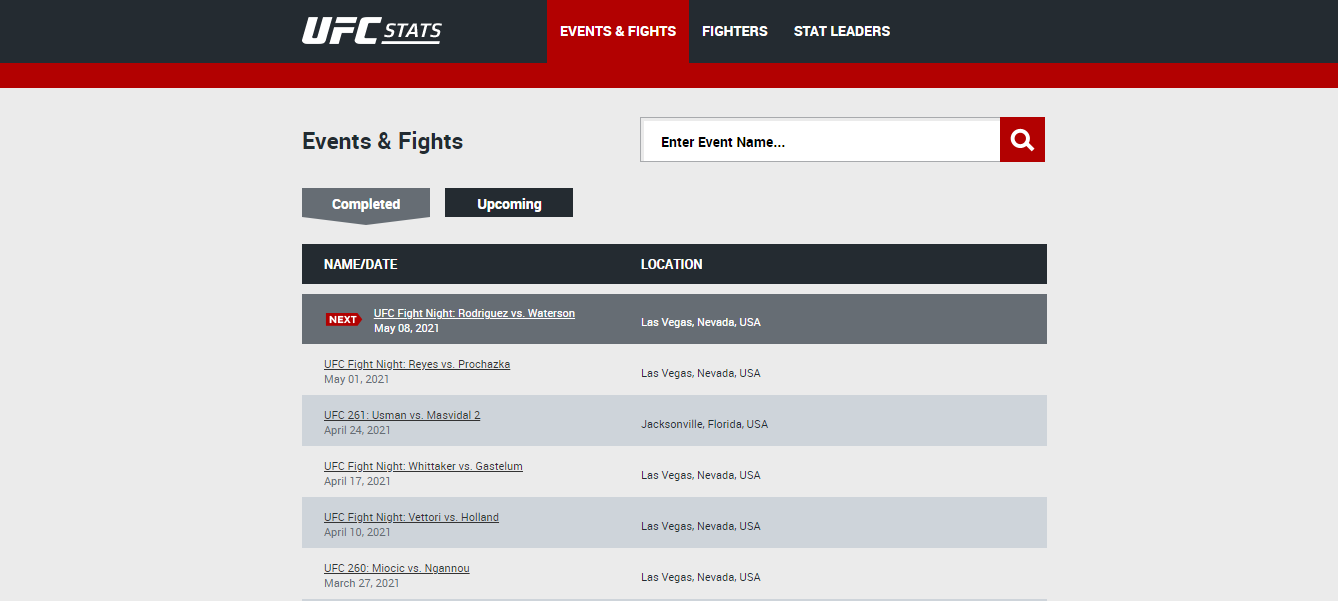

Le site est assez complet et recence les statistiques de chaque combat (nombre de coup portés, localisation des coups portés, nombre de KnockDown ...)

Voici par exemple un extrait des statistiques du combat entre Kamaru Usman et Jorge Masvidal qui a eu lieu le 24 avril dernier :

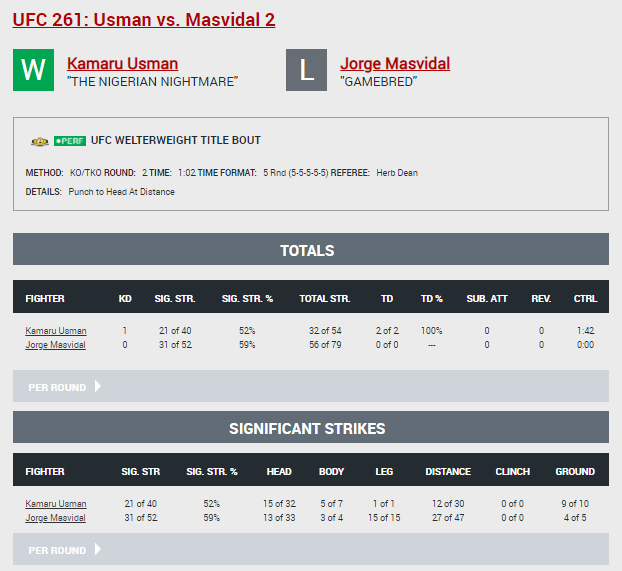

Avant d'expliquer exactement quelles statistiques nous allons récupérer, collectons d'abord la liste de TOUS les combats disponibles sur ce site.

On défini tout d'abord une fonction RequeteUrl qui nous permet d'ouvrir un lien passé en paramètre et de retourner la page de ce lien sous forme de page balisée en html

In [2]:
def RequeteUrl(url):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    request_test = urlopen(req).read()
    page = bs4.BeautifulSoup(request_test, "lxml")
    return page

Ensuite petite présentation du fonctionnnement des événements UFC :

Chaque samedi soir un "Event" UFC a lieu, il est composé d'une grosse dizaine de combats

La première tâche est donc de récupérer le lien de tous les combats de chaque event!

On stocke donc le lien de la liste de tous les events dans une variable url

In [3]:
url="http://www.ufcstats.com/statistics/events/completed?page=all"

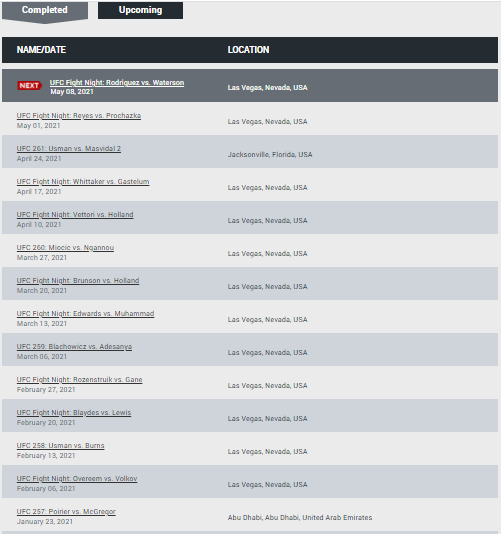

On ouvre le lien et on extrait le code de la page:

In [4]:
page = RequeteUrl(url)

L'url des pages de chaque event est contenu dans des balises <a dans la variable "href"

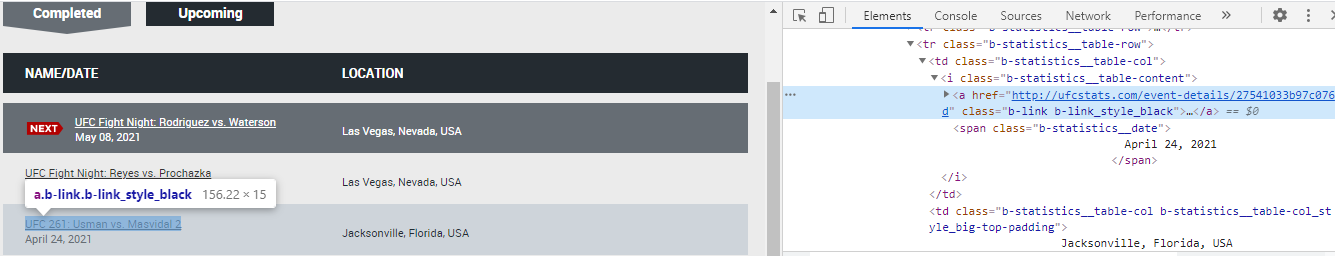

In [5]:
LiensEvenements = [a.get('href') for a in page.findAll('a', {'class':'b-link b-link_style_black'})]

On a donc dans la variable "LiensEvenements" les url de tous les events ufc

In [6]:
LiensEvenements

['http://www.ufcstats.com/event-details/ef61d9f5176b3200',
 'http://www.ufcstats.com/event-details/89a407032911e27e',
 'http://www.ufcstats.com/event-details/2719f300b0439039',
 'http://www.ufcstats.com/event-details/d2fa318f34d0aadc',
 'http://www.ufcstats.com/event-details/6f81b6de2557739a',
 'http://www.ufcstats.com/event-details/ccd58ff71e260ed5',
 'http://www.ufcstats.com/event-details/1174782eacde9b0c',
 'http://www.ufcstats.com/event-details/c9885b1b7c7055a0',
 'http://www.ufcstats.com/event-details/6085ceb59087514b',
 'http://www.ufcstats.com/event-details/e9e1acc96536bb4f',
 'http://www.ufcstats.com/event-details/a780d16cf7eed44d',
 'http://www.ufcstats.com/event-details/b9415726dc3ec526',
 'http://www.ufcstats.com/event-details/b6c6d1731ff00eeb',
 'http://www.ufcstats.com/event-details/7abe471b61725980',
 'http://www.ufcstats.com/event-details/6f812143641ceff8',
 'http://www.ufcstats.com/event-details/901cddcbfa079097',
 'http://www.ufcstats.com/event-details/3c6976f8182d9527

Maintenant nous allons devoir "ouvrir" chaque url des events pour récupérer les url des combats situées dans une balise <tr dans la variable "data-link"

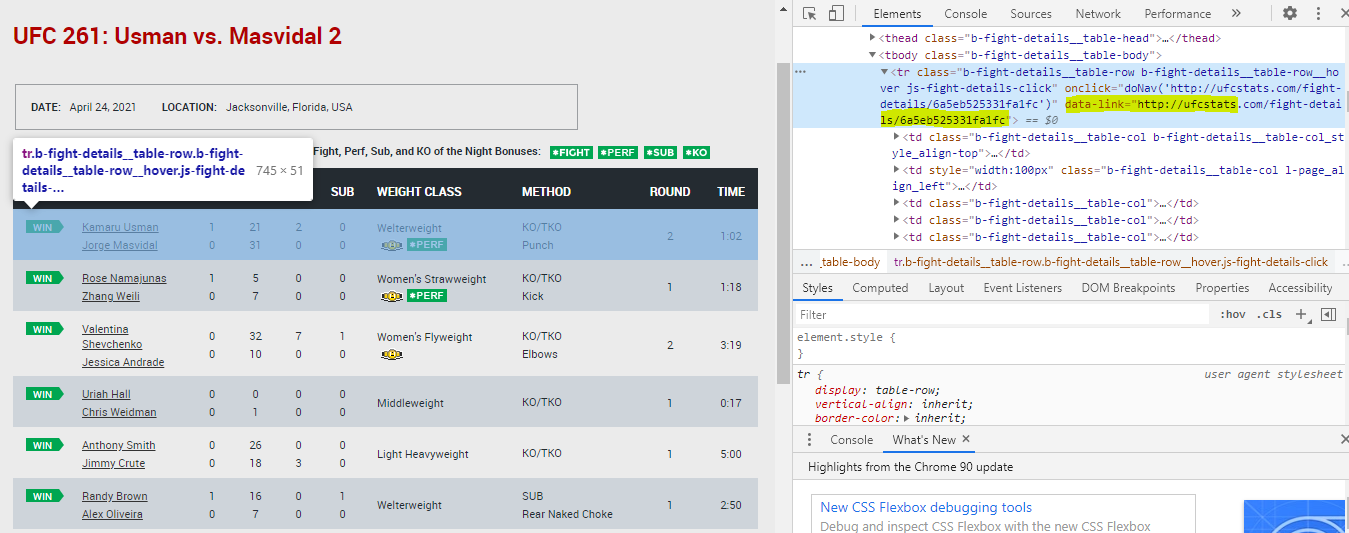

In [7]:
# Initialisation du tableau qui contiendra la liste des url des combats
Combat=[]

# On fait une boucle pour parcourir tout les events stockés dans le tableau "LiensEvenements"
for i in range (len(LiensEvenements)): 
    # Compteur pour connaitre l'avancée du programme
    print(str(i+1)+'/'+str(len(LiensEvenements)))
    # On ouvre la page de l'event
    page=RequeteUrl(LiensEvenements[i])
    # On recupere les liens des combats de l'event i qu'on ajoute au tableau Combat
    Combat=Combat+[a.get('data-link') for a in page.findAll('tr',{'class':"b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click"})]

1/661
2/661
3/661
4/661
5/661
6/661
7/661
8/661
9/661
10/661
11/661
12/661
13/661
14/661
15/661
16/661
17/661
18/661
19/661
20/661
21/661
22/661
23/661
24/661
25/661
26/661
27/661
28/661
29/661
30/661
31/661
32/661
33/661
34/661
35/661
36/661
37/661
38/661
39/661
40/661
41/661
42/661
43/661
44/661
45/661
46/661
47/661
48/661
49/661
50/661
51/661
52/661
53/661
54/661
55/661
56/661
57/661
58/661
59/661
60/661
61/661
62/661
63/661
64/661
65/661
66/661
67/661
68/661
69/661
70/661
71/661
72/661
73/661
74/661
75/661
76/661
77/661
78/661
79/661
80/661
81/661
82/661
83/661
84/661
85/661
86/661
87/661
88/661
89/661
90/661
91/661
92/661
93/661
94/661
95/661
96/661
97/661
98/661
99/661
100/661
101/661
102/661
103/661
104/661
105/661
106/661
107/661
108/661
109/661
110/661
111/661
112/661
113/661
114/661
115/661
116/661
117/661
118/661
119/661
120/661
121/661
122/661
123/661
124/661
125/661
126/661
127/661
128/661
129/661
130/661
131/661
132/661
133/661
134/661
135/661
136/661
137/661
138/661
139/

On se retrouve avec plus de 7300 url de combat

In [8]:
len(Combat)

7317

## b) Récupération des données

Maintenant que nous avons les url de tous nos combats nous pouvons récupérer les données que nous fournirons à notre modèle.

Nous devons donc pour chaque combat récupérer :
* les caractéristiques du combat: vainqueur, catégorie de poids du combat, est-ce un combat pour le titre ...
* les statistiques des combats précédents de chaque combattant: Le nombre de coups qu'il a donnés et reçus, le nombre de combats qu'il a faits, la localisation des coups donnés et reçus dans sa carrière ...
* les statistiques "globales" de chaque combattant: âge, poids, taille ... 

Commençons dans un premier temps par récupérer les statistiques "globales" d'un combattant

Voilà comment se présente la page d'un combattant sur le site de l'ufc :

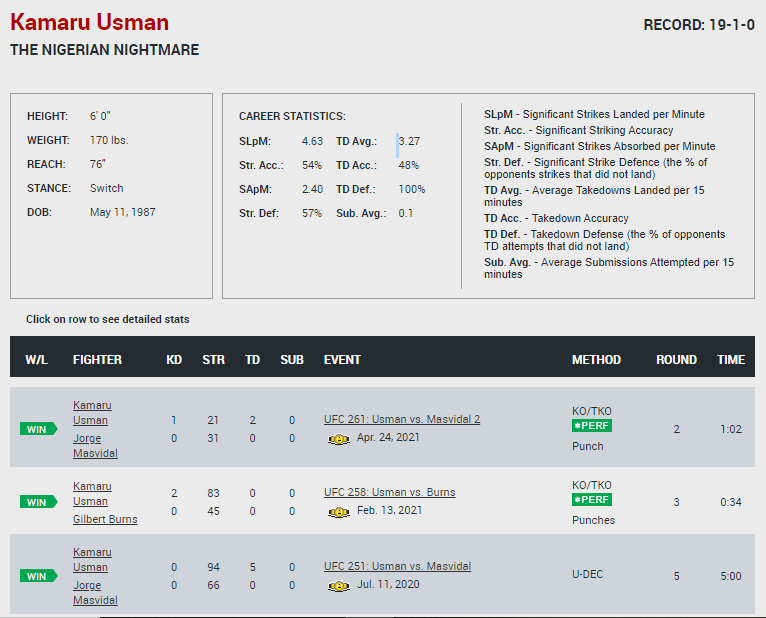

C'est donc le premier encadré en haut à gauche qui nous intéressera pour cette partie.
Il va nous permettre de récupérer :
* la taille : HEIGHT
* le poids : WEIGHT (son poids de prédilection / son poids de la vie de tous les jours)
* l'allonge : REACH
* la position : STANCE (si le combattant a une garde de gaucher, droitier ou ambidextre)
* la date de naissance : DOB (qui nous permettra de calculer son âge lors de chaque combat)

Nous ne regarderons pas l'encadré suivant : Career statistics car il regroupe les statistiques de toute sa carrière à la date du jour et non à la date du combat étudié.

On crée donc une fonction CaraCombattant qui va prendre en paramètre l'url de la page d'un combattant et qui nous retournera les caractéristiques précédement listées.
Nous verrons plus tard comment récupérer les url des combattants à partir des pages des combats.

In [9]:
def CaraCombattant(lien):
    
    # Ouvre la page du combattant
    p = RequeteUrl(lien)
    
    # On recupere la taille qui est toujours le premier elements des balises:
    # <li comportant une class=b-list__box-list-item b-list__box-list-item_type_block
    Taille = p.findAll('li',{'class':'b-list__box-list-item b-list__box-list-item_type_block'})[0].getText().strip().replace('\n', '')
    # La taille est de la forme:
    # HEIGHT: 6' 0"
    # Il faut donc isoler les pieds et les pouces pour convertir en cm
    Pied = int(Taille[Taille.find("'")-1])
    Pouce = int(Taille[Taille.find("'")+1:len(Taille)-1])
    Taille = Pied*30.48+Pouce*2.54
    
    # Le poid est le deuxiemme des mêmes balises
    # il est de la forme
    # WEIGHT: 170 lbs.
    # un .split() nous sert donc a isoler les mots et donc supprimer le lbs et le Weight
    Poids = p.findAll('li',{'class':'b-list__box-list-item b-list__box-list-item_type_block'})[1].getText().strip().replace('\n', '').split()[-2]
    # Il faut ensuite le convertir en kg
    Poids = int(Poids)/2.205
    
    # Même chose avec l'allonge qui est le 3ème elements    
    Allonge = p.findAll('li',{'class':'b-list__box-list-item b-list__box-list-item_type_block'})[2].getText().strip().replace('\n', '')
    # Elle est de la forme:
    # REACH: 76"
    # Il faut donc trouver le " mais egalement trouver ou le chiffre commence
    c = Allonge.find('"')-1
    while(Allonge[c]!=' '):
        c = c-1
    # Dans certains cas (rare) l'allonge n'est pas indiquée et elle est remplacé par -- 
    # Chez les etre humain l'allonge est en moyenne 1,038 fois la taille de la personne.
    # Quand l'allonge n'est pas indiqué on la remplace par 1,038 fois la taille pour eviter d'avoir des valeurs nulles
    # Sinon on la convertie en cm
    if(Allonge.find('-') != -1):
        Allonge = 1.038*Taille
    else:
        Allonge = int(Allonge[c+1:Allonge.find('"')])*2.54
    
    # La position est le 4ème element des balises
    # Elle est de la forme: 
    # STANCE: Switch
    # Il suffit donc de séparer les mots et prendre le dernier a chaque fois pour etre sur de ne garder que la position
    Stance = p.findAll('li',{'class':'b-list__box-list-item b-list__box-list-item_type_block'})[3].getText().strip().replace('\n', '').split()[-1]
    
    # La Date de naissance est le 5ème element des balises
    # Elle est de la forme: 
    # DOB: May 11, 1987
    Dob = p.findAll('li',{'class':'b-list__box-list-item b-list__box-list-item_type_block'})[4].getText().strip().replace('\n', '')
    # Nous prevoyons, comme pour l'allonge, les cas ou la date de naissance ne sera pas précisé:
    # Dans ce cas la nous fixerons la date a None
    if(Dob.find('-') != -1):
        Dob = None
    else:
        # Nous separons les differents elements de la date 
        Dob = Dob.split()
        # Nous recuperons le mois 
        Mois = Dob[1]
        # On transforme le Mois en chiffre
        if(Mois=='Jan'):
            Mois = 1
        if(Mois=='Feb'):
            Mois = 2
        if(Mois=='Mar'):
            Mois = 3
        if(Mois=='Apr'):
            Mois = 4
        if(Mois=='May'):
            Mois = 5
        if(Mois=='Jun'):
            Mois = 6
        if(Mois=='Jul'):
            Mois = 7
        if(Mois=='Aug'):
            Mois = 8
        if(Mois=='Sep'):
            Mois = 9
        if(Mois=='Oct'):
            Mois = 10
        if(Mois=='Nov'):
            Mois = 11
        if(Mois=='Dec'):
            Mois = 12
        # On crée ensuite un objet date (pour le jour ne pas prendre la virgule)
        Dob = datetime.datetime(int(Dob[3]), Mois,int(Dob[2][0:2])).date()

    return([Taille,Poids,Allonge,Stance,Dob])

Voilà ce que nous retourne cette fonction pour la page de Kamaru Usman présentée plus haut:

In [10]:
CaraCombattant("http://ufcstats.com/fighter-details/f1b2aa7853d1ed6e")

[182.88, 77.09750566893423, 193.04, 'Switch', datetime.date(1987, 5, 11)]

Maintenant nous allons récupérer les statistiques des combats précédents pour un combattant

Il faut donc à partir de la page d'un combattant récupérer la liste de ses combats précédents

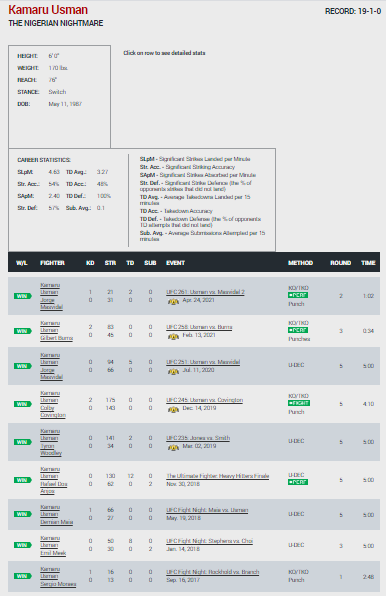

Puis pour chaque combat aller voir sur la page du combat le nombre de coups etc qui ont été donnés

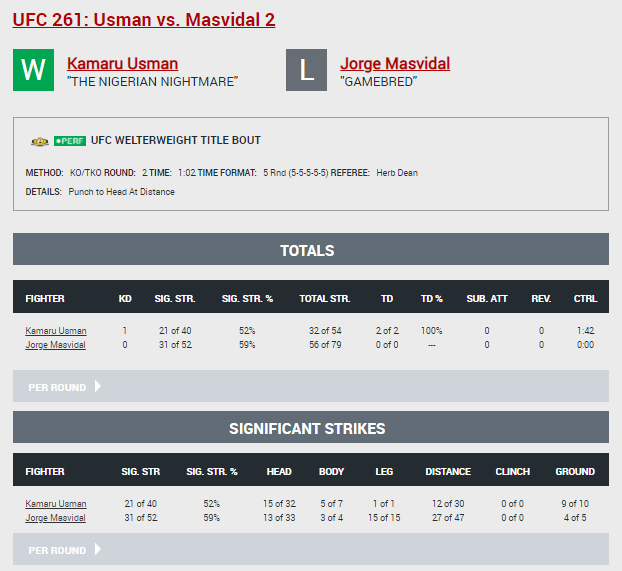

Nous allons récupérer les statistiques suivantes :
* gagné ou perdu
* date du combat 
* titre en jeu ou non 
* durée du combat
* Le nombre de KnockDown donnés / reçus
* Le nombre total de coups qui ont touché (donnés / reçus)
* Le nombre total de coups (donnés / reçus)
* Le nombre de TakeDown réussis (donnés / reçus)
* Le nombre de TakeDown total (donnés / reçus)
* Les tentatives de soumisions (données / reçues)
* Le nombre de "renversement" (donnés / reçus)
* Le temps de contrôle du combattant / de l'adversaire (au corps à corps et au sol)
* Les coups significatifs qui ont touchés à la tête / au corps / aux jambes (donnés / reçus)
* Les coups significatifs au total à la tête / au corps / aux jambes (donnés / reçus)
* Les coups significatifs qui ont touché de loin / au corps à corps / au sol (donnés / reçus)
* Les coups significatifs au total de loin / au corps a corps / au sol (donnés / reçus)


On crée donc une fonction qui va prendre en paramètres l'url d'un combattant, son nom ainsi que la date de l'event courant (pour pouvoir ne conserver que les statistiques des combats précédants le combat "actuel"):

In [11]:
def CombatsPrecedents (lien, NomCombattant,DateEvent):
    
    # On charge la page du combattant
    pa = RequeteUrl(lien)
    
    # On initialise notr DataFrame 
    CombatPrecedent = pd.DataFrame(columns = ['Gagne','Date','Title','TempsCombat',\
                                              'KD','KDRecu','TotStrikeReussi','TotStrikeReussiRecu',\
                                              'TotStrikeTot','TotStrikeTotRecu','TDReussi','TDReussiRecu','TDTot','TDTotRecu',\
                                              'SubAttempt','SubAttemptRecu','Rev','RevRecu','Ctrl','CtrlRecu',\
                                              'StrikeHeadReussi','StrikeHeadReussiRecu','StrikeHeadTot','StrikeHeadTotRecu',\
                                              'StrikeBodyReussi','StrikeBodyReussiRecu','StrikeBodyTot','StrikeBodyTotRecu',\
                                              'StrikeLegReussi','StrikeLegReussiRecu','StrikeLegTot','StrikeLegTotRecu',\
                                              'StrikeDistanceReussi','StrikeDistanceReussiRecu',\
                                              'StrikeDistanceTot','StrikeDistanceTotRecu',\
                                              'StrikeClinchReussi','StrikeClinchReussiRecu',\
                                              'StrikeClinchTot','StrikeClinchTotRecu',\
                                              'StrikeGroundReussi','StrikeGroundReussiRecu','StrikeGroundTot','StrikeGroundTotRecu'])

    # On recupere dans un tableau les "blocs de balises" de chaque combat 
    # On est toujours sur la page du combattant
    Combats = pa.findAll('tr',{'class':'b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click'})

    # On parcours maintenant chaque "bloc" qui correspond a un ancien combat
    for i in range (len(Combats)):
        
        page = Combats[i]
        
        # On stock dans un boolean si le combat a été remporté par le combattant ou pas
        Win = page.find("i").getText()
        if(Win=='win'):
            Win = 1
        else:
            Win = 0
            
        # On crée un boolean pour dire si le combat était pour le titre ou non
        Title = 0
        # Un combat pour le titre est symbolisé par une image de ceinture a coté de la date
        img = page.findAll('img')
        # On parcours les images du combat (il peut y avoir des image pour recompenser les combat de la soirée ...)
        for j in range (len(img)):
            # Si on trouve la petite image de ceinture c'est que c'est un combat pour le titre
            if(img[j].get('src')=='http://1e49bc5171d173577ecd-1323f4090557a33db01577564f60846c.r80.cf1.rackcdn.com/belt.png'):
                Title = 1 
             
        # On recupere la date du combat (meme principe que pour la date de naissance de la fonction précédente)
        Date = page.findAll('p')[12].getText().strip().split()
        
        Mois = Date[0][0:len(Date)]

        if(Mois=='Jan'):
            Mois = 1
        if(Mois=='Feb'):
            Mois = 2
        if(Mois=='Mar'):
            Mois = 3
        if(Mois=='Apr'):
            Mois = 4
        if(Mois=='May'):
            Mois = 5
        if(Mois=='Jun'):
            Mois = 6
        if(Mois=='Jul'):
            Mois = 7
        if(Mois=='Aug'):
            Mois = 8
        if(Mois=='Sep'):
            Mois = 9
        if(Mois=='Oct'):
            Mois = 10
        if(Mois=='Nov'):
            Mois = 11
        if(Mois=='Dec'):
            Mois = 12

        Date = datetime.datetime(int(Date[2]), Mois,int(Date[1][0:2])).date()

        # On recupère le temps du combat 
        # Pour cela on recupere le nombre de round
        Round = int(page.findAll('p')[-2].getText().strip())
        # Ainsi que le temps ecoulé dans le dernier round
        Temps = page.findAll('p')[-1].getText().strip()
        # il est de la forme 
        # 1:02
        # on le veut en secondes
        Temps = int(Temps[0:Temps.find(':')])*60 + int(Temps[Temps.find(':')+1:])
        
        # Le temps total est donc le nombre de round - 1 fois 5 min plus le temps ecoulé dans le dernier round
        TempsCombat = (Round-1)*5*60+Temps

        #On recupere ensuite le lien de la page du combat pour aller chercher les coups ect 
        LienCombat = page.get('data-link')

        # On ouvre la page du combat
        PageCombat = RequeteUrl(LienCombat)

        # Il faut dans un premier temps trouver "la ligne" de notre combattant
        # En effet dans le tabeau des statistique du combat on sait pas si notre combattant correspond à la 1ere ou 2eme ligne
        if (PageCombat.findAll('a',{'class':'b-link b-fight-details__person-link'})[0].getText().strip()==NomCombattant):
            Indice = 0
            IndiceAdversaire = 1
        else:
            Indice = 1
            IndiceAdversaire = 0
        # Grace a l'indice on saura desormais quels coups correspondent aux recus et lesquels correspondent aux données

        # Les Tableau de statistique correspondent au "blocs tbody"
        # Le tbody[0] : stats totales
        # Le tbody[1] : round par round
        # Le tbody[2] : frappes significatives
        # Le tbody[3] : round par round
        # Nous aurons besoin de regarder le 0 et le 2 nous ne preocupons pas du round par round
        Total = PageCombat.findAll('tbody')
        # On se "protege" des combats dont les stats ne sont pas renseignées
        # (C'est arrivé ... ^^)
        # Dans se cas la on sautera le combat ...
        if(len(Total)!=0):
            
            Total = PageCombat.findAll('tbody')[0]

            # On n'a plus qu'a recuperer les statistiques en jouant sur les bons indices
            
            KD = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[2+Indice].getText())
            KDRecu = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[2+IndiceAdversaire].getText())

            TotStrike = Total.findAll('p',{'class':'b-fight-details__table-text'})[8+Indice].getText().strip().split()
            TotStrikeReussi = int(TotStrike[0])
            TotStrikeTot = int(TotStrike[-1])

            TotStrike = Total.findAll('p',{'class':'b-fight-details__table-text'})[8+IndiceAdversaire].getText().strip().split()
            TotStrikeReussiRecu = int(TotStrike[0])
            TotStrikeTotRecu = int(TotStrike[-1])

            TD = Total.findAll('p',{'class':'b-fight-details__table-text'})[10+Indice].getText().strip().split()
            TDReussi = int(TD[0])
            TDTot = int(TD[-1])

            TD = Total.findAll('p',{'class':'b-fight-details__table-text'})[10+IndiceAdversaire].getText().strip().split()
            TDReussiRecu = int(TD[0])
            TDTotRecu = int(TD[-1])

            SubAttempt = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[14+Indice].getText().strip())
            SubAttemptRecu = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[14+IndiceAdversaire].getText().strip())

            Rev = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[16+Indice].getText().strip())
            RevRecu = int(Total.findAll('p',{'class':'b-fight-details__table-text'})[16+IndiceAdversaire].getText().strip())

            Ctrl = Total.findAll('p',{'class':'b-fight-details__table-text'})[18+Indice].getText().strip()
            CtrlRecu = Total.findAll('p',{'class':'b-fight-details__table-text'})[18+IndiceAdversaire].getText().strip()

            # Si le Control est egale a "--" il faut le considerer comme nulle
            if(Ctrl == '--'):
                Ctrl = '0:00'
            if(CtrlRecu == '--'):
                CtrlRecu = '0:00'

            # On transforme ensuite le temps en seconde 
            Ctrl = int(Ctrl[0:Ctrl.find(':')])*60 + int(Ctrl[Ctrl.find(':')+1:])
            CtrlRecu = int(CtrlRecu[0:CtrlRecu.find(':')])*60 + int(CtrlRecu[CtrlRecu.find(':')+1:])

            # On passe ensuite au deuxieme tableau de statistique (les frappes significatives)
            Total = PageCombat.findAll('tbody')[2]

            StrikeHead = Total.findAll('p',{'class':'b-fight-details__table-text'})[6+Indice].getText().strip().split()
            StrikeHeadReussi = int(StrikeHead[0])
            StrikeHeadTot = int(StrikeHead[-1])

            StrikeHead = Total.findAll('p',{'class':'b-fight-details__table-text'})[6+IndiceAdversaire].getText().strip().split()
            StrikeHeadReussiRecu = int(StrikeHead[0])
            StrikeHeadTotRecu = int(StrikeHead[-1])

            StrikeBody = Total.findAll('p',{'class':'b-fight-details__table-text'})[8+Indice].getText().strip().split()
            StrikeBodyReussi = int(StrikeBody[0])
            StrikeBodyTot = int(StrikeBody[-1])

            StrikeBody = Total.findAll('p',{'class':'b-fight-details__table-text'})[8+IndiceAdversaire].getText().strip().split()
            StrikeBodyReussiRecu = int(StrikeBody[0])
            StrikeBodyTotRecu = int(StrikeBody[-1])

            StrikeLeg = Total.findAll('p',{'class':'b-fight-details__table-text'})[10+Indice].getText().strip().split()
            StrikeLegReussi = int(StrikeLeg[0])
            StrikeLegTot = int(StrikeLeg[-1])

            StrikeLeg = Total.findAll('p',{'class':'b-fight-details__table-text'})[10+IndiceAdversaire].getText().strip().split()
            StrikeLegReussiRecu = int(StrikeLeg[0])
            StrikeLegTotRecu = int(StrikeLeg[-1])

            StrikeDistance = Total.findAll('p',{'class':'b-fight-details__table-text'})[12+Indice].getText().strip().split()
            StrikeDistanceReussi = int(StrikeDistance[0])
            StrikeDistanceTot = int(StrikeDistance[-1])

            StrikeDistance = Total.findAll('p',{'class':'b-fight-details__table-text'})[12+IndiceAdversaire].getText().strip().split()
            StrikeDistanceReussiRecu = int(StrikeDistance[0])
            StrikeDistanceTotRecu = int(StrikeDistance[-1])

            StrikeClinch = Total.findAll('p',{'class':'b-fight-details__table-text'})[14+Indice].getText().strip().split()
            StrikeClinchReussi = int(StrikeClinch[0])
            StrikeClinchTot = int(StrikeClinch[-1])

            StrikeClinch = Total.findAll('p',{'class':'b-fight-details__table-text'})[14+IndiceAdversaire].getText().strip().split()
            StrikeClinchReussiRecu = int(StrikeClinch[0])
            StrikeClinchTotRecu = int(StrikeClinch[-1])

            StrikeGround = Total.findAll('p',{'class':'b-fight-details__table-text'})[16+Indice].getText().strip().split()
            StrikeGroundReussi = int(StrikeGround[0])
            StrikeGroundTot = int(StrikeGround[-1])

            StrikeGround = Total.findAll('p',{'class':'b-fight-details__table-text'})[16+IndiceAdversaire].getText().strip().split()
            StrikeGroundReussiRecu = int(StrikeGround[0])
            StrikeGroundTotRecu = int(StrikeGround[-1])

            # Une fois que tout nos statistiques sont récupéré on les ajoutes au DataFrame
            CombatPrecedent.loc[i] = [Win,Date,Title,TempsCombat,\
                                                  KD,KDRecu,TotStrikeReussi,TotStrikeReussiRecu,\
                                                  TotStrikeTot,TotStrikeTotRecu,TDReussi,TDReussiRecu,TDTot,TDTotRecu,\
                                                  SubAttempt,SubAttemptRecu,Rev,RevRecu,Ctrl,CtrlRecu,\
                                                  StrikeHeadReussi,StrikeHeadReussiRecu,StrikeHeadTot,StrikeHeadTotRecu,\
                                                  StrikeBodyReussi,StrikeBodyReussiRecu,StrikeBodyTot,StrikeBodyTotRecu,\
                                                  StrikeLegReussi,StrikeLegReussiRecu,StrikeLegTot,StrikeLegTotRecu,\
                                                  StrikeDistanceReussi,StrikeDistanceReussiRecu,\
                                                  StrikeDistanceTot,StrikeDistanceTotRecu,\
                                                  StrikeClinchReussi,StrikeClinchReussiRecu,\
                                                  StrikeClinchTot,StrikeClinchTotRecu,\
                                                  StrikeGroundReussi,StrikeGroundReussiRecu,StrikeGroundTot,StrikeGroundTotRecu]

    # On retourne ensuite seulement les combats précedent le combat qu'on est en train de collecter
    return CombatPrecedent.iloc[np.where(CombatPrecedent['Date']<DateEvent)[0]]

Voici ce que la fonction retourne pour le combattant Kamaru Usman 

In [12]:
CombatsPrecedents('http://ufcstats.com/fighter-details/f1b2aa7853d1ed6e','Kamaru Usman',datetime.date(2023, 3,18))

,Gagne,Date,Title,TempsCombat,KD,KDRecu,TotStrikeReussi,TotStrikeReussiRecu,TotStrikeTot,TotStrikeTotRecu,TDReussi,TDReussiRecu,TDTot,TDTotRecu,SubAttempt,SubAttemptRecu,Rev,RevRecu,Ctrl,CtrlRecu,StrikeHeadReussi,StrikeHeadReussiRecu,StrikeHeadTot,StrikeHeadTotRecu,StrikeBodyReussi,StrikeBodyReussiRecu,StrikeBodyTot,StrikeBodyTotRecu,StrikeLegReussi,StrikeLegReussiRecu,StrikeLegTot,StrikeLegTotRecu,StrikeDistanceReussi,StrikeDistanceReussiRecu,StrikeDistanceTot,StrikeDistanceTotRecu,StrikeClinchReussi,StrikeClinchReussiRecu,StrikeClinchTot,StrikeClinchTotRecu,StrikeGroundReussi,StrikeGroundReussiRecu,StrikeGroundTot,StrikeGroundTotRecu
1,0,2022-08-20,1,1444,0,1,189,64,247,85,5,1,12,5,0,1,0,0,636,175,61,20,109,38,17,22,21,24,5,13,5,13,46,42,85,62,15,7,22,7,22,6,28,6
2,1,2021-11-06,1,1500,2,0,158,119,336,298,1,0,1,11,0,0,0,0,76,114,80,79,241,242,41,23,50,33,2,5,2,6,107,101,274,274,6,6,7,7,10,0,12,0
3,1,2021-04-24,1,362,1,0,32,56,54,79,2,0,2,0,0,0,0,0,102,0,15,13,32,33,5,3,7,4,1,15,1,15,12,27,30,47,0,0,0,0,9,4,10,5
4,1,2021-02-13,1,634,2,0,93,55,149,124,0,0,0,3,0,0,0,0,125,0,56,18,105,75,11,13,15,14,16,14,16,19,54,44,100,104,3,1,4,4,26,0,32,0
5,1,2020-07-11,1,1500,0,0,263,88,341,157,5,0,16,0,0,0,0,0,998,0,43,23,96,69,49,29,53,39,2,14,2,17,42,38,86,90,39,27,49,34,13,1,16,1
6,1,2019-12-14,1,1450,2,0,175,143,360,395,0,0,0,0,0,0,0,0,11,0,116,103,279,341,53,28,74,39,6,12,7,15,156,143,340,395,5,0,5,0,14,0,15,0
7,1,2019-03-02,1,1500,0,0,336,60,390,79,2,0,6,1,0,0,0,0,1093,0,56,12,104,28,83,18,87,19,2,4,3,4,27,10,73,24,78,24,82,27,36,0,39,0
8,1,2018-11-30,0,1500,0,0,227,84,334,138,12,0,18,1,0,2,0,1,1107,21,95,27,183,74,29,19,34,20,6,16,6,18,48,35,111,83,33,22,43,24,49,5,69,5
9,1,2018-05-19,0,1500,1,0,97,33,244,94,0,0,0,15,0,0,0,0,259,121,49,26,181,85,4,1,12,2,13,0,16,0,55,25,187,85,1,1,5,1,10,1,17,1
10,1,2018-01-14,0,900,0,0,112,86,132,131,8,0,19,0,0,2,0,0,771,2,29,20,44,54,9,7,10,10,12,3,12,3,8,17,15,48,8,4,8,4,34,9,43,15


Nous devons maintenant "synthétiser" ces informations pour qu'elles tiennent sur une seule ligne de notre DataFrame final. Nous allons donc sommer les variables: nous aurons donc la somme des coups recus / données etc au cours de la carrière du combattant.

Or en sommant nous donnerions autant d'importance à un combat qui s'est déroulé il y a 5 ans qu'au dernier combat de ce combattant. 

Pour pallier cela nous allons sommer les combats avec une certaine pondération. Plus le combat sera ancien plus le poids sera faible:

* Le combat précédent a forcément une pondération de 5
* Moins d'un mois => 4,5
* Entre 1 mois et 6 mois => 3
* Entre 6 mois et 1 an => 2,5
* Entre 1 an et 1 an et demi => 2
* Entre 1 an et demi et 2 ans => 1
* Entre 2 ans et 5 ans => 0,75
* Entre 5 ans et 10 ans => 0,25


La fonction suivante ajoute donc une colonne pondération au DataFrame des combats précédents:

In [13]:
def Ponderation (df,date):
    
    # On ajoute une feature ponderation dans le DataFrame
    df['Ponderation'] = 0
    df.loc[(df['Date']<date) & (df['Date']>date-datetime.timedelta(days=30)), 'Ponderation'] = 4.5
    df.loc[(df['Date']<date-datetime.timedelta(days=30)) & (df['Date']>date-datetime.timedelta(days=182)),'Ponderation'] = 3
    df.loc[(df['Date']<date-datetime.timedelta(days=182)) & (df['Date']>date-datetime.timedelta(days=365)),'Ponderation'] = 2.5
    df.loc[(df['Date']<date-datetime.timedelta(days=365)) & (df['Date']>date-datetime.timedelta(days=547)),'Ponderation'] = 2
    df.loc[(df['Date']<date-datetime.timedelta(days=547)) & (df['Date']>date-datetime.timedelta(days=730)),'Ponderation'] = 1
    df.loc[(df['Date']<date-datetime.timedelta(days=730)) & (df['Date']>date-datetime.timedelta(days=1825)),'Ponderation'] = 0.75
    df.loc[(df['Date']<date-datetime.timedelta(days=1825)) & (df['Date']>date-datetime.timedelta(days=3650)),'Ponderation'] = 0.25
    # On attribut une ponderation elevé au premier
    if(len(df.index)!=0):
        df.loc[df.index[0],'Ponderation']=5
    
    return (df)

Il nous manque néanmoins quelques features et quelques informations.

En effet pour les fonctions précédentes nous devions récupérer:
* Les liens des combattants
* Les noms des combattants
* La date du combat

Il nous manque également :
* l'issue du combat (qui sera notre Y et la variable à prédire)
* Le nom de l'event (pas utile dans notre dataset mais utile pour checker la cohérence et retrouver des combats plus facilement)
* La catégorie de poids du combat

Nous pouvons donc créer notre dernière fonction qui récupèrera les dernières informations manquantes puis fera appel aux fonctions précédentes pour retourner un array comportant toutes nos features pour un combat. 

In [14]:
def CaraCombat(lien):
    
    # Ouvre la page du combat    
    page = RequeteUrl(lien)
    
    # Partie Event
    # On ouvre la page de l'Event
    # Notament pour recuperer la date du combat uniquement disponible sur la page de l'Event
    PageEvent = RequeteUrl(page.find('a',{'class':'b-link'}).get('href'))
    
    # La date est de forme
    # April 24, 2021
    # On a donc pas besoin de transformer le mois
    Date = PageEvent.findAll('li',{"class":"b-list__box-list-item"})[0].getText().strip().replace('\n', '').split()
    Date = datetime.datetime.strptime(Date[1], '%B').replace(year=int(Date[-1])).replace(day=int(Date[2][0:-1])).date()
    
    NomEvent = PageEvent.findAll('span')[0].getText().strip().replace('\n', '')
    
    # Retour sur la page du combat
    
    # On recupere le vainqueur
    # 1 pour le 1er combattant
    # 2 pour le 2eme
    # On recupere egalement le nom ainsi que les url des 2 combattants
    Victoire = 0

    r=page.findAll('div',{'class':'b-fight-details__person'})

    for i in range (len(r)):
        if (i==0):
            Combattant1 = r[i].find("a").getText().strip()
            LienC1 = r[i].find('a').get('href')
        else:
            Combattant2 = r[i].find("a").getText().strip()
            LienC2 = r[i].find('a').get('href')

        w = r[i].find("i").getText().strip()
        if (w=='W'):
            Victoire = i+1
            
    # On recupere la categorie 
    # Elle a la forme:
    # UFC WELTERWEIGHT TITLE BOUT
    Categorie = page.findAll('i',{'class':'b-fight-details__fight-title'})[0].getText().strip()

    # Si c'est un combat pour le titre le mot "Title" est contenu dans la categorie
    if(page.findAll('i',{'class':'b-fight-details__fight-title'})[0].getText().strip().find('Title')!=-1):
        Titre = 1
    else:
        Titre = 0

    # On supprime ensuite certains mots pour ne garder que la categorie du combat 
    stopwords = ['ufc', 'title', 'bout']
    querywords = Categorie.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    Categorie = ' '.join(resultwords)
    
    # On recupere ensuite les caracteristiques des combattants grace a la fonctions créée precedement
    # (Taille,Poids,Allonge,Position de garde,Date de naissance)
    CaracteristiqueC1 = CaraCombattant(LienC1)
    CaracteristiqueC2 = CaraCombattant(LienC2)
    
    # On remplace ensuite la Date de naissance par la difference entre la date de l'event et la date de naissance
    # pour ainsi obtenir l'age du combattant lors du combat
    if(CaracteristiqueC1[-1] == None):
        CaracteristiqueC1[-1] = None
    else:
        CaracteristiqueC1[-1] = (Date-CaracteristiqueC1[-1]).days
        
    if(CaracteristiqueC2[-1] == None):
        CaracteristiqueC2[-1] = None
    else:
        CaracteristiqueC2[-1] = (Date-CaracteristiqueC2[-1]).days
    
    # On recupere les 2 DataFrame des statistiques des combats precedents des 2 combattants
    # On passe les 2 DataFrame dans la fonction ponderation pour ajouter nos ponderations
    CombatPrecC1 = Ponderation(CombatsPrecedents(LienC1,Combattant1,Date),Date)
    CombatPrecC2 = Ponderation(CombatsPrecedents(LienC2,Combattant2,Date),Date)
    
    # On multiplie ensuite chaque colonne de nos DataFrame par nos ponderations
    CombatPrecC1[['Gagne','Title','TempsCombat',\
                    'KD','KDRecu','TotStrikeReussi','TotStrikeReussiRecu',\
                    'TotStrikeTot','TotStrikeTotRecu','TDReussi','TDReussiRecu','TDTot','TDTotRecu',\
                    'SubAttempt','SubAttemptRecu','Rev','RevRecu','Ctrl','CtrlRecu',\
                    'StrikeHeadReussi','StrikeHeadReussiRecu','StrikeHeadTot','StrikeHeadTotRecu',\
                    'StrikeBodyReussi','StrikeBodyReussiRecu','StrikeBodyTot','StrikeBodyTotRecu',\
                    'StrikeLegReussi','StrikeLegReussiRecu','StrikeLegTot','StrikeLegTotRecu',\
                    'StrikeDistanceReussi','StrikeDistanceReussiRecu',\
                    'StrikeDistanceTot','StrikeDistanceTotRecu',\
                    'StrikeClinchReussi','StrikeClinchReussiRecu',\
                    'StrikeClinchTot','StrikeClinchTotRecu',\
                    'StrikeGroundReussi','StrikeGroundReussiRecu','StrikeGroundTot','StrikeGroundTotRecu'\
                  ]] = CombatPrecC1[['Gagne','Title','TempsCombat',\
                    'KD','KDRecu','TotStrikeReussi','TotStrikeReussiRecu',\
                    'TotStrikeTot','TotStrikeTotRecu','TDReussi','TDReussiRecu','TDTot','TDTotRecu',\
                    'SubAttempt','SubAttemptRecu','Rev','RevRecu','Ctrl','CtrlRecu',\
                    'StrikeHeadReussi','StrikeHeadReussiRecu','StrikeHeadTot','StrikeHeadTotRecu',\
                    'StrikeBodyReussi','StrikeBodyReussiRecu','StrikeBodyTot','StrikeBodyTotRecu',\
                    'StrikeLegReussi','StrikeLegReussiRecu','StrikeLegTot','StrikeLegTotRecu',\
                    'StrikeDistanceReussi','StrikeDistanceReussiRecu',\
                    'StrikeDistanceTot','StrikeDistanceTotRecu',\
                    'StrikeClinchReussi','StrikeClinchReussiRecu',\
                    'StrikeClinchTot','StrikeClinchTotRecu',\
                    'StrikeGroundReussi','StrikeGroundReussiRecu','StrikeGroundTot','StrikeGroundTotRecu'\
                  ]].multiply(CombatPrecC1["Ponderation"], axis="index")
    
    CombatPrecC2[['Gagne','Title','TempsCombat',\
                    'KD','KDRecu','TotStrikeReussi','TotStrikeReussiRecu',\
                    'TotStrikeTot','TotStrikeTotRecu','TDReussi','TDReussiRecu','TDTot','TDTotRecu',\
                    'SubAttempt','SubAttemptRecu','Rev','RevRecu','Ctrl','CtrlRecu',\
                    'StrikeHeadReussi','StrikeHeadReussiRecu','StrikeHeadTot','StrikeHeadTotRecu',\
                    'StrikeBodyReussi','StrikeBodyReussiRecu','StrikeBodyTot','StrikeBodyTotRecu',\
                    'StrikeLegReussi','StrikeLegReussiRecu','StrikeLegTot','StrikeLegTotRecu',\
                    'StrikeDistanceReussi','StrikeDistanceReussiRecu',\
                    'StrikeDistanceTot','StrikeDistanceTotRecu',\
                    'StrikeClinchReussi','StrikeClinchReussiRecu',\
                    'StrikeClinchTot','StrikeClinchTotRecu',\
                    'StrikeGroundReussi','StrikeGroundReussiRecu','StrikeGroundTot','StrikeGroundTotRecu'\
                  ]] = CombatPrecC2[['Gagne','Title','TempsCombat',\
                    'KD','KDRecu','TotStrikeReussi','TotStrikeReussiRecu',\
                    'TotStrikeTot','TotStrikeTotRecu','TDReussi','TDReussiRecu','TDTot','TDTotRecu',\
                    'SubAttempt','SubAttemptRecu','Rev','RevRecu','Ctrl','CtrlRecu',\
                    'StrikeHeadReussi','StrikeHeadReussiRecu','StrikeHeadTot','StrikeHeadTotRecu',\
                    'StrikeBodyReussi','StrikeBodyReussiRecu','StrikeBodyTot','StrikeBodyTotRecu',\
                    'StrikeLegReussi','StrikeLegReussiRecu','StrikeLegTot','StrikeLegTotRecu',\
                    'StrikeDistanceReussi','StrikeDistanceReussiRecu',\
                    'StrikeDistanceTot','StrikeDistanceTotRecu',\
                    'StrikeClinchReussi','StrikeClinchReussiRecu',\
                    'StrikeClinchTot','StrikeClinchTotRecu',\
                    'StrikeGroundReussi','StrikeGroundReussiRecu','StrikeGroundTot','StrikeGroundTotRecu'\
                  ]].multiply(CombatPrecC2["Ponderation"], axis="index")
    
    # On supprime ensuite les colonnes dates 
    CombatPrecC1 = CombatPrecC1.drop(columns = ['Date'])
    CombatPrecC2 = CombatPrecC2.drop(columns = ['Date'])
    
    # Puis on fait la somme de chaque colonne de nos DataFrame des combats precedents
    SumCombatPrecC1 = CombatPrecC1.sum().values
    SumCombatPrecC2 = CombatPrecC2.sum().values
    
    # On fini par retourner un array contenant toute les informations pour un combat
    return (np.append(np.append(np.array([Date,NomEvent,Victoire,Combattant1,LienC1,Combattant2,LienC2,Categorie,Titre]\
            +CaracteristiqueC1+CaracteristiqueC2),SumCombatPrecC1),SumCombatPrecC2))

Voici le résultat pour le combat de Kamaru Usman et Leon Edwards:

In [15]:
import time
start_time = time.time()
print(CaraCombat('http://ufcstats.com/fight-details/c483ac06b1e33c3b'))
print("--- %s seconds ---" % (time.time() - start_time))

[datetime.date(2023, 3, 18) 'UFC 286: Edwards vs. Usman 3' 1
 'Leon Edwards' 'http://ufcstats.com/fighter-details/f1fac969a1d70b08'
 'Kamaru Usman' 'http://ufcstats.com/fighter-details/f1b2aa7853d1ed6e'
 'Welterweight' 1 187.96 77.09750566893423 187.96 'Southpaw' 11528 182.88
 77.09750566893423 193.04 'Switch' 13095 10.0 5.0 13655.5 6.5 0.25 725.25
 1395.0 1154.25 2003.25 15.75 32.0 52.75 85.75 6.25 0.5 0.75 0.0 2290.25
 4245.75 296.25 441.5 662.75 933.0 167.75 154.25 202.75 200.0 121.5 70.0
 127.75 91.0 441.0 433.75 825.25 911.25 84.0 110.0 95.75 153.5 60.5 122.0
 72.25 159.25 11.25 9.25 11.25 17906.75 9.25 5.0 2357.75 1013.5 3573.75
 1950.25 50.25 5.0 108.75 62.0 0.5 7.25 0.0 0.75 6961.0 1220.0 843.25
 449.5 1882.0 1284.75 362.25 248.0 443.75 300.5 76.0 138.25 82.0 150.5
 778.0 685.75 1763.5 1568.75 214.75 108.0 276.0 122.5 288.75 42.0 368.25
 44.5 14.25]
--- 157.64548802375793 seconds ---


## c) DataSet Final

On crée un DataFrame contenant toutes nos features :

In [16]:
DataSet = pd.DataFrame(columns = [\
                                  'Date','NomEvent','Victoire','Combattant1','LienC1','Combattant2','LienC2','Categorie','Titre',\
                                  'Taille1','Poids1','Allonge1','Stance1','Age1',\
                                  'Taille2','Poids2','Allonge2','Stance2','Age2',\
                                  'Gagne1','Title1','TempsCombat1',\
                                  'KD1','KDRecu1','TotStrikeReussi1','TotStrikeReussiRecu1',\
                                  'TotStrikeTot1','TotStrikeTotRecu1','TDReussi1','TDReussiRecu1','TDTot1','TDTotRecu1',\
                                  'SubAttempt1','SubAttemptRecu1','Rev1','RevRecu1','Ctrl1','CtrlRecu1',\
                                  'StrikeHeadReussi1','StrikeHeadReussiRecu1','StrikeHeadTot1','StrikeHeadTotRecu1',\
                                  'StrikeBodyReussi1','StrikeBodyReussiRecu1','StrikeBodyTot1','StrikeBodyTotRecu1',\
                                  'StrikeLegReussi1','StrikeLegReussiRecu1','StrikeLegTot1','StrikeLegTotRecu1',\
                                  'StrikeDistanceReussi1','StrikeDistanceReussiRecu1',\
                                  'StrikeDistanceTot1','StrikeDistanceTotRecu1',\
                                  'StrikeClinchReussi1','StrikeClinchReussiRecu1',\
                                  'StrikeClinchTot1','StrikeClinchTotRecu1',\
                                  'StrikeGroundReussi1','StrikeGroundReussiRecu1','StrikeGroundTot1','StrikeGroundTotRecu1',\
                                  'NbCombatPonderation1',\
                                  'Gagne2','Title2','TempsCombat2',\
                                  'KD2','KDRecu2','TotStrikeReussi2','TotStrikeReussiRecu2',\
                                  'TotStrikeTot2','TotStrikeTotRecu2','TDReussi2','TDReussiRecu2','TDTot2','TDTotRecu2',\
                                  'SubAttempt2','SubAttemptRecu2','Rev2','RevRecu2','Ctrl2','CtrlRecu2',\
                                  'StrikeHeadReussi2','StrikeHeadReussiRecu2','StrikeHeadTot2','StrikeHeadTotRecu2',\
                                  'StrikeBodyReussi2','StrikeBodyReussiRecu2','StrikeBodyTot2','StrikeBodyTotRecu2',\
                                  'StrikeLegReussi2','StrikeLegReussiRecu2','StrikeLegTot2','StrikeLegTotRecu2',\
                                  'StrikeDistanceReussi2','StrikeDistanceReussiRecu2',\
                                  'StrikeDistanceTot2','StrikeDistanceTotRecu2',\
                                  'StrikeClinchReussi2','StrikeClinchReussiRecu2',\
                                  'StrikeClinchTot2','StrikeClinchTotRecu2',\
                                  'StrikeGroundReussi2','StrikeGroundReussiRecu2','StrikeGroundTot2','StrikeGroundTotRecu2',\
                                  'NbCombatPonderation2'\
                                 ])

Nous n'avons plus qu'à faire une boucle pour parcourir l'intégralité de nos combats et les ajouter à notre dataset

Nous nous arrêterons au combat 4200 et quelques pour arriver fin 2011. Le MMA étant un sport récent (années 90) il est en évolution constante et les combattants sont de plus en plus complets. Cela ne sert donc pas à grand chose d'entraîner notre modèle sur des combats qui ont 20 ans. 

Notre boucle permet d'enregistrer le DataSet dans un fichier csv tout les 100 combats. C'est assez long de scrapper toutes les statistiques (~ 2 jours). Et si cette boucle plante il faut la relancer en chargeant la derniere sauvegarde du DataSet.

In [ ]:
for c in range(0,4328):
    DataSet.loc[c] = CaraCombat(Combat[c])
    print(c)
    if(((c%100) == 0)&(c>0)):
        DataSet.to_csv("C:/Users/elgha/OneDrive/Bureau/Abdou/Etudes/scrappingUFC/Test"+str(c)+".csv")


Une fois fini nous enregistrons notre dataset final dans un fichier csv

In [28]:
DataSet.to_csv("C:/Users/elgha/OneDrive/Bureau/Abdou/Etudes/scrappingUFC/Scrappingxcl/final.csv")

# 3) Preprocessing

Voilà notre DataSet final:

In [21]:
Df = pd.read_csv("C:/Users/elgha/OneDrive/Bureau/Abdou/Etudes/scrappingUFC/Scrappingxcl/final.csv",index_col=0)
Df

,Date,NomEvent,Victoire,Combattant1,LienC1,Combattant2,LienC2,Categorie,Titre,Taille1,Poids1,Allonge1,Stance1,Age1,Taille2,Poids2,Allonge2,Stance2,Age2,Gagne1,Title1,TempsCombat1,KD1,KDRecu1,TotStrikeReussi1,TotStrikeReussiRecu1,TotStrikeTot1,TotStrikeTotRecu1,TDReussi1,TDReussiRecu1,TDTot1,TDTotRecu1,SubAttempt1,SubAttemptRecu1,Rev1,RevRecu1,Ctrl1,CtrlRecu1,StrikeHeadReussi1,StrikeHeadReussiRecu1,StrikeHeadTot1,StrikeHeadTotRecu1,StrikeBodyReussi1,StrikeBodyReussiRecu1,StrikeBodyTot1,StrikeBodyTotRecu1,StrikeLegReussi1,StrikeLegReussiRecu1,StrikeLegTot1,StrikeLegTotRecu1,StrikeDistanceReussi1,StrikeDistanceReussiRecu1,StrikeDistanceTot1,StrikeDistanceTotRecu1,StrikeClinchReussi1,StrikeClinchReussiRecu1,StrikeClinchTot1,StrikeClinchTotRecu1,StrikeGroundReussi1,StrikeGroundReussiRecu1,StrikeGroundTot1,StrikeGroundTotRecu1,NbCombatPonderation1,Gagne2,Title2,TempsCombat2,KD2,KDRecu2,TotStrikeReussi2,TotStrikeReussiRecu2,TotStrikeTot2,TotStrikeTotRecu2,TDReussi2,TDReussiRecu2,TDTot2,TDTotRecu2,SubAttempt2,SubAttemptRecu2,Rev2,RevRecu2,Ctrl2,CtrlRecu2,StrikeHeadReussi2,StrikeHeadReussiRecu2,StrikeHeadTot2,StrikeHeadTotRecu2,StrikeBodyReussi2,StrikeBodyReussiRecu2,StrikeBodyTot2,StrikeBodyTotRecu2,StrikeLegReussi2,StrikeLegReussiRecu2,StrikeLegTot2,StrikeLegTotRecu2,StrikeDistanceReussi2,StrikeDistanceReussiRecu2,StrikeDistanceTot2,StrikeDistanceTotRecu2,StrikeClinchReussi2,StrikeClinchReussiRecu2,StrikeClinchTot2,StrikeClinchTotRecu2,StrikeGroundReussi2,StrikeGroundReussiRecu2,StrikeGroundTot2,StrikeGroundTotRecu2,NbCombatPonderation2
1,26/08/2023,UFC Fight Night: Holloway vs. The Korean Zombie,1,Max Holloway,http://www.ufcstats.com/fighter-details/150ff4...,Chan Sung Jung,http://www.ufcstats.com/fighter-details/c451d6...,Featherweight,0,180.34,65.759637,175.26000,Orthodox,11588,170.18,65.759637,182.88,Orthodox,13311,11.25,6.50,20663.75,1.25,0.00,2590.75,1754.50,4949.50,4005.25,4.75,7.25,13.50,55.25,3.5,0.00,0.00,1.25,729.75,1143.00,1488.75,1094.5,3586.50,3052.00,619.25,247.25,780.00,434.50,312.00,342.50,399.25,442.50,2232.50,1593.50,4532.50,3796.00,131.25,86.75,155.50,124.25,56.25,4.00,77.75,8.75,15.50,2.50,5.00,8328.50,1.75,7.25,593.50,1069.00,1286.00,1711.25,2.25,22.25,7.75,55.75,2.25,0.00,0.00,0.00,523.25,1105.75,372.75,644.00,1007.50,1212.75,66.25,104.00,85.50,135.75,61.75,198.25,81.5,226.00,422.50,815.25,1084.25,1404.75,32.50,66.50,35.50,82.25,45.75,64.50,54.75,87.50,9.00
2,26/08/2023,UFC Fight Night: Holloway vs. The Korean Zombie,1,Anthony Smith,http://www.ufcstats.com/fighter-details/d4c9dc...,Ryan Spann,http://www.ufcstats.com/fighter-details/a67f5a...,Light Heavyweight,0,193.04,92.970522,193.04000,Orthodox,12814,195.58,92.970522,200.66,Orthodox,11690,5.50,0.75,11335.75,3.25,2.00,580.00,1379.00,1186.75,2317.50,8.00,14.50,27.25,23.75,4.5,0.00,0.25,1.00,924.00,2713.75,290.50,466.5,804.00,1217.25,116.00,133.00,190.00,217.75,104.25,395.25,119.50,437.75,465.75,715.00,1045.00,1509.25,25.00,80.75,41.75,111.25,20.00,199.00,26.75,252.25,15.25,8.50,0.00,3747.75,5.75,2.25,182.75,317.50,400.25,499.25,8.75,20.50,22.50,26.75,10.25,11.75,10.75,10.75,745.50,1342.50,145.50,108.25,359.25,272.25,28.50,36.00,31.50,40.75,0.75,32.50,1.5,33.25,124.75,106.50,323.75,250.50,18.75,30.00,24.00,45.75,31.25,40.25,44.50,50.00,15.50
3,26/08/2023,UFC Fight Night: Holloway vs. The Korean Zombie,1,Giga Chikadze,http://www.ufcstats.com/fighter-details/9560ff...,Alex Caceres,http://www.ufcstats.com/fighter-details/7aa3d6...,Featherweight,0,182.88,65.759637,187.96000,Orthodox,12784,177.80,65.759637,185.42,Southpaw,12850,5.50,0.00,11337.00,5.00,5.00,920.50,965.25,2327.75,2564.00,1.50,14.75,4.00,52.25,2.0,5.25,6.50,5.00,191.00,1422.00,615.00,732.5,1893.75,2198.75,197.25,105.25,297.75,203.75,79.50,49.00,102.00,65.25,847.75,822.75,2218.00,2381.25,8.50,16.75,22.25,19.00,35.50,47.25,53.25,67.50,10.75,13.00,0.00,11961.50,4.00,1.75,1086.00,748.25,1839.00,1640.25,10.50,24.75,20.25,91.50,3.00,8.00,6.75,6.75,1969.25,2595.25,537.50,288.25,1189.50,1066.75,255.25,99.25,316

Au MMA des matchs nuls peuvent arriver. Ils sont rares et à priori très compliqués à prédire ... Nous allons donc tout simplement les supprimer de notre dataframe.
Nous allons également supprimer les combats dont les 2 combattants ont des statistiques nulles. Pour cela nous allons repérer les combats dont les statistiques TotStrikeReussiRecu et StrikeBodyReussiRecu sont égales à 0

In [22]:
Df = Df.drop(np.where((Df['Victoire']==0)|((Df['StrikeBodyReussiRecu1']==0) & (Df['TotStrikeReussiRecu1']==0))&((Df['StrikeBodyReussiRecu2']==0) & (Df['TotStrikeReussiRecu2']==0) ))[0])
Df = Df.reset_index(drop=True)

Il y a également beaucoup de catégories qui nous avaient échappé (les tournois, combats interims ...). Nous allons donc nettoyer la feature "Catégorie" en ne gardant que les catégories présentes à l'UFC:

In [23]:
Df['Categorie'].unique()

array(['Featherweight', 'Light Heavyweight', 'Bantamweight',
       "Women's Flyweight", 'Heavyweight', 'Middleweight', 'Welterweight',
       "Women's Strawweight", 'Lightweight', 'Catch Weight', 'Flyweight',
       "Women's Bantamweight", "Women's Featherweight",
       'Interim Featherweight', 'Interim Flyweight',
       'Interim Bantamweight', 'Interim Heavyweight',
       'Interim Lightweight', 'Interim Middleweight',
       "Ultimate Fighter 28 Women's Featherweight Tournament",
       'Ultimate Fighter 27 Featherweight Tournament',
       'Interim Welterweight',
       'Ultimate Fighter 25 Welterweight Tournament',
       'Ultimate Fighter Latin America 3 Lightweight Tournament',
       "Ultimate Fighter 23 Women's Strawweight Tournament",
       'Ultimate Fighter 22 Lightweight Tournament',
       'Ultimate Fighter Latin America 2 Lightweight Tournament',
       'Ultimate Fighter Brazil 4 Bantamweight Tournament'], dtype=object)

In [24]:
for i in range (len(Df)):
    
    Cate = ['Light','Heavyweight', 'Featherweight', 'Middleweight',
       'Bantamweight', "Women's","Strawweight", "Flyweight",
       'Welterweight', 'Lightweight', 'Flyweight', 'Heavyweight',
       "Bantamweight", 'Catch','Weight']
    
    querywords = Df.loc[i,'Categorie'].split()
    

    resultwords  = [word for word in querywords if word in Cate]
    Df.loc[i,'Categorie'] = ' '.join(resultwords)

In [25]:
Df['Categorie'].unique()

array(['Featherweight', 'Light Heavyweight', 'Bantamweight',
       "Women's Flyweight", 'Heavyweight', 'Middleweight', 'Welterweight',
       "Women's Strawweight", 'Lightweight', 'Catch Weight', 'Flyweight',
       "Women's Bantamweight", "Women's Featherweight"], dtype=object)

Nous supprimons également les lignes dont la feature "Stance" est nulle:

In [26]:
Df = Df.drop(np.where((Df['Stance1'] == 'STANCE:') | (Df['Stance1'] == 'Stance') )[0])
Df = Df.reset_index(drop=True)
Df = Df.drop(np.where((Df['Stance2'] == 'STANCE:') | (Df['Stance2'] == 'Stance') )[0])
Df = Df.reset_index(drop=True)

Nous n'avons plus qu'à isoler notre feature "Victoire" dans un DataFrame Y et nos autres variables dans un DataFrame X.
nous transformons également nos variables non numériques (Catégorie et Stance) grâce à un one hot encoding:

In [27]:
Y = Df['Victoire']
X = Df[['Titre',\
          'Taille1','Poids1','Allonge1','Age1',\
          'Taille2','Poids2','Allonge2','Age2',\
          'Gagne1','Title1','TempsCombat1',\
          'KD1','KDRecu1','TotStrikeReussi1','TotStrikeReussiRecu1',\
          'TotStrikeTot1','TotStrikeTotRecu1','TDReussi1','TDReussiRecu1','TDTot1','TDTotRecu1',\
          'SubAttempt1','SubAttemptRecu1','Rev1','RevRecu1','Ctrl1','CtrlRecu1',\
          'StrikeHeadReussi1','StrikeHeadReussiRecu1','StrikeHeadTot1','StrikeHeadTotRecu1',\
          'StrikeBodyReussi1','StrikeBodyReussiRecu1','StrikeBodyTot1','StrikeBodyTotRecu1',\
          'StrikeLegReussi1','StrikeLegReussiRecu1','StrikeLegTot1','StrikeLegTotRecu1',\
          'StrikeDistanceReussi1','StrikeDistanceReussiRecu1',\
          'StrikeDistanceTot1','StrikeDistanceTotRecu1',\
          'StrikeClinchReussi1','StrikeClinchReussiRecu1',\
          'StrikeClinchTot1','StrikeClinchTotRecu1',\
          'StrikeGroundReussi1','StrikeGroundReussiRecu1','StrikeGroundTot1','StrikeGroundTotRecu1',\
          'NbCombatPonderation1',\
          'Gagne2','Title2','TempsCombat2',\
          'KD2','KDRecu2','TotStrikeReussi2','TotStrikeReussiRecu2',\
          'TotStrikeTot2','TotStrikeTotRecu2','TDReussi2','TDReussiRecu2','TDTot2','TDTotRecu2',\
          'SubAttempt2','SubAttemptRecu2','Rev2','RevRecu2','Ctrl2','CtrlRecu2',\
          'StrikeHeadReussi2','StrikeHeadReussiRecu2','StrikeHeadTot2','StrikeHeadTotRecu2',\
          'StrikeBodyReussi2','StrikeBodyReussiRecu2','StrikeBodyTot2','StrikeBodyTotRecu2',\
          'StrikeLegReussi2','StrikeLegReussiRecu2','StrikeLegTot2','StrikeLegTotRecu2',\
          'StrikeDistanceReussi2','StrikeDistanceReussiRecu2',\
          'StrikeDistanceTot2','StrikeDistanceTotRecu2',\
          'StrikeClinchReussi2','StrikeClinchReussiRecu2',\
          'StrikeClinchTot2','StrikeClinchTotRecu2',\
          'StrikeGroundReussi2','StrikeGroundReussiRecu2','StrikeGroundTot2','StrikeGroundTotRecu2',\
          'NbCombatPonderation2']]

Ohe = Df[['Categorie','Stance1','Stance2']]
Ohe = pd.get_dummies(Ohe)

Df_X = pd.concat([X,Ohe],axis=1)

# 4) Modélisation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(Df_X, Y, test_size = 0.33)

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
classifier = RandomForestClassifier(n_estimators = 1000)

In [31]:
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [32]:
X_pred = classifier.predict(X_test)

In [33]:
print(confusion_matrix(y_test, X_pred))

[[  1  24   7]
 [  0 626 143]
 [  0 377 167]]


In [34]:
print(classification_report(y_test, X_pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        32
           1       0.61      0.81      0.70       769
           2       0.53      0.31      0.39       544

    accuracy                           0.59      1345
   macro avg       0.71      0.38      0.38      1345
weighted avg       0.59      0.59      0.56      1345



In [35]:
print(accuracy_score(X_pred,y_test))

0.5903345724907063


Feature: 0, Score: 0.00053
Feature: 1, Score: 0.00906
Feature: 2, Score: 0.00758
Feature: 3, Score: 0.00994
Feature: 4, Score: 0.02613
Feature: 5, Score: 0.00925
Feature: 6, Score: 0.00707
Feature: 7, Score: 0.01065
Feature: 8, Score: 0.02512
Feature: 9, Score: 0.01232
Feature: 10, Score: 0.00387
Feature: 11, Score: 0.01112
Feature: 12, Score: 0.00780
Feature: 13, Score: 0.00895
Feature: 14, Score: 0.01221
Feature: 15, Score: 0.01205
Feature: 16, Score: 0.01050
Feature: 17, Score: 0.01060
Feature: 18, Score: 0.01003
Feature: 19, Score: 0.00993
Feature: 20, Score: 0.01230
Feature: 21, Score: 0.01151
Feature: 22, Score: 0.00855
Feature: 23, Score: 0.00835
Feature: 24, Score: 0.00633
Feature: 25, Score: 0.00632
Feature: 26, Score: 0.01250
Feature: 27, Score: 0.01255
Feature: 28, Score: 0.01257
Feature: 29, Score: 0.01318
Feature: 30, Score: 0.01128
Feature: 31, Score: 0.01092
Feature: 32, Score: 0.01083
Feature: 33, Score: 0.01171
Feature: 34, Score: 0.01096
Feature: 35, Score: 0.01154
Fe

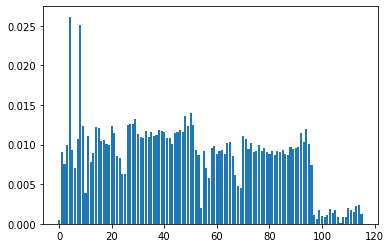

In [36]:
importance = classifier.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()